In [46]:
import numpy as np
import matplotlib.pyplot as plt
import deeptime
from deeptime.markov.msm import BayesianMSM
from deeptime.markov import TransitionCountEstimator
from deeptime.plots.chapman_kolmogorov import plot_ck_test
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
import MDAnalysis as mda
import nglview as nv
from MDAnalysis.analysis import align, diffusionmap, rms
import mdtraj as md
import glob

import matplotlib
import seaborn as sns
sns.set_style("ticks")
sns.set_context(font_scale=0.8,context='poster')
sns.set_context({"figure.figsize": (12, 12)})

In [124]:
def get_helicity(trajectory, topology, start=100, plotted=False):
    traj = md.load(trajectory,top=topology, stride=1, )
    nframes = traj.n_frames

    phi = md.compute_phi(traj,periodic=True)
    psi = md.compute_psi(traj,periodic=True)

    phi_alpha = -1.01
    psi_alpha = -0.82

    cos_phi = 0.5*(1+np.cos(phi[1]-phi_alpha))
    cos_psi = 0.5*(1+np.cos(psi[1]-psi_alpha))

    ndihedrals = cos_phi.shape[1]

    alpha_vs_t = np.zeros((nframes,ndihedrals))

    for i in range(nframes):
        ind_phi = np.where(cos_phi[i,:]>0.95)[0]
        ind_psi = np.where(cos_psi[i,:]>0.95)[0]
        ind_alpha = np.intersect1d(ind_phi,ind_psi)
        alpha_vs_t[i,ind_alpha] = 1

    alpha_vs_t_sum = np.sum(alpha_vs_t, axis=1)

    if plotted:
        fig, axes = plt.subplots(1,2,figsize=(10,2.5))

        axes[0].plot(traj.time / 1000, alpha_vs_t_sum/ndihedrals,'royalblue')
        axes[0].set_xlabel('time (ns)')
        axes[0].set_ylabel('alpha helicity')
        axes[0].set_ylim(-0.1,1)


        axes[1].hist(alpha_vs_t_sum,bins=ndihedrals+1,range=[-0.5,ndihedrals+0.5],density=True,stacked=True,color='skyblue',ec='black',lw=1)
        axes[1].set_xlabel('number of residues')
        axes[1].set_ylabel('probability')
        plt.tight_layout()

        plt.show()
    return alpha_vs_t[start:], alpha_vs_t_sum[start:]

In [125]:
topology = '../ALA16/protein.pdb'
trajectories = sorted(glob.glob('../ALA16/rep*/whole.xtc'), key=lambda x: int(x.split('/')[2].split('rep')[1].split('/')[0]))

print(trajectories)

['../ALA16/rep1/whole.xtc', '../ALA16/rep2/whole.xtc', '../ALA16/rep3/whole.xtc', '../ALA16/rep4/whole.xtc', '../ALA16/rep5/whole.xtc', '../ALA16/rep6/whole.xtc', '../ALA16/rep7/whole.xtc', '../ALA16/rep8/whole.xtc', '../ALA16/rep9/whole.xtc', '../ALA16/rep10/whole.xtc', '../ALA16/rep11/whole.xtc', '../ALA16/rep12/whole.xtc', '../ALA16/rep13/whole.xtc', '../ALA16/rep14/whole.xtc', '../ALA16/rep15/whole.xtc', '../ALA16/rep16/whole.xtc']


In [126]:
dt = md.load(trajectories[0],top=topology, stride=1).time[1] - md.load(trajectories[0],top=topology, stride=1).time[0]
dt = dt / 1000 # ns
print('dt is {} ns'.format(dt))

dt is 0.4 ns


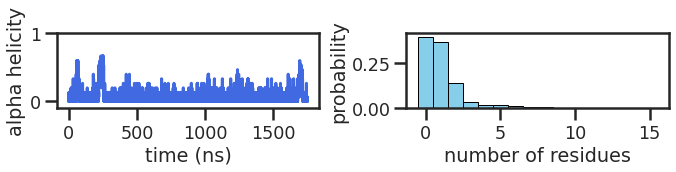

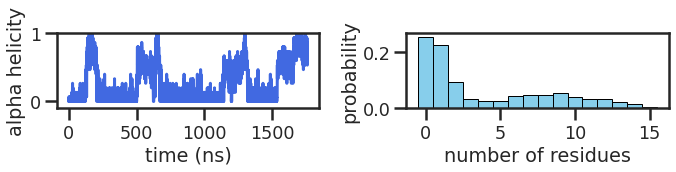

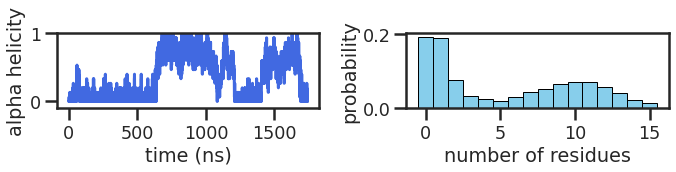

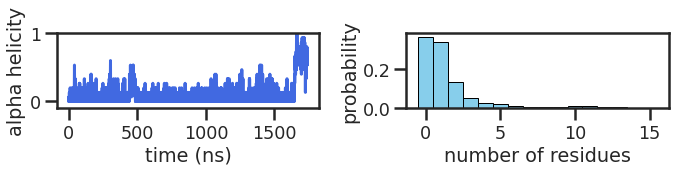

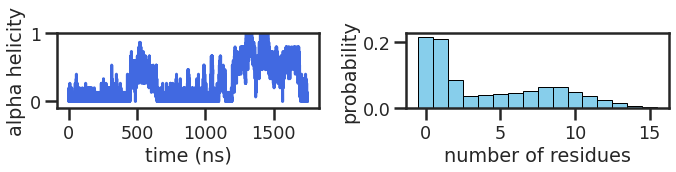

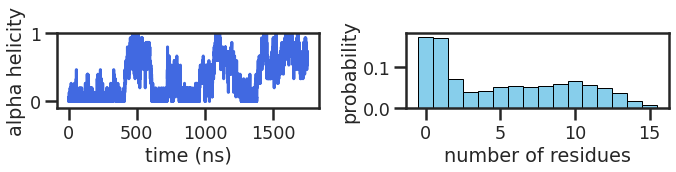

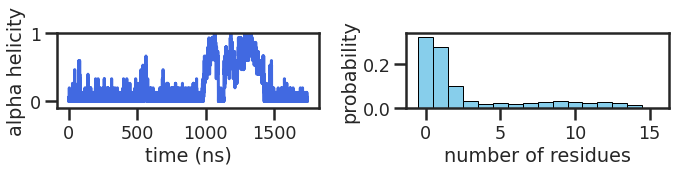

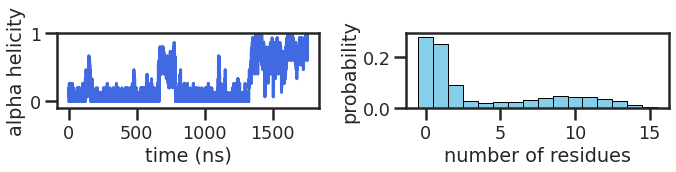

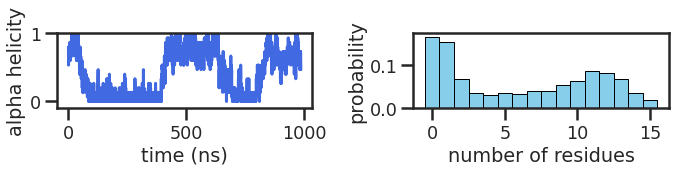

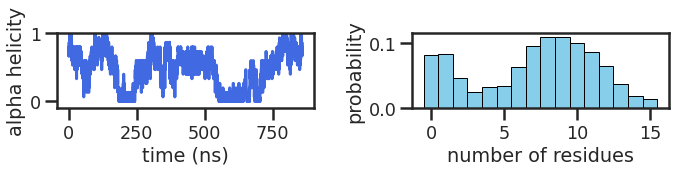

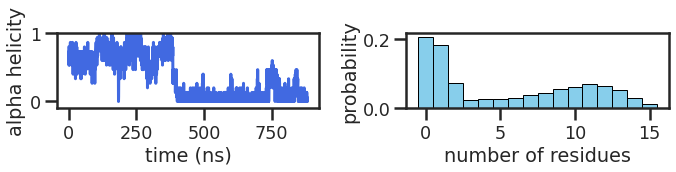

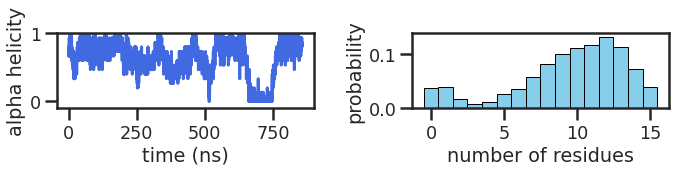

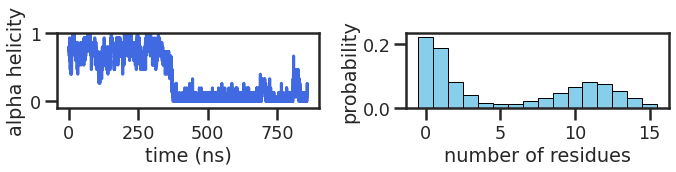

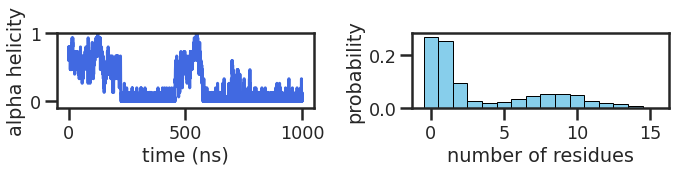

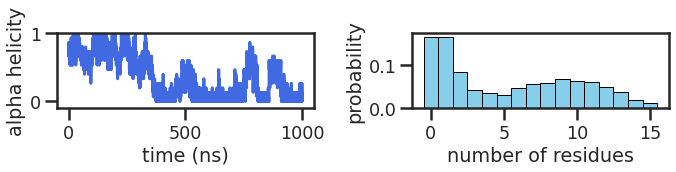

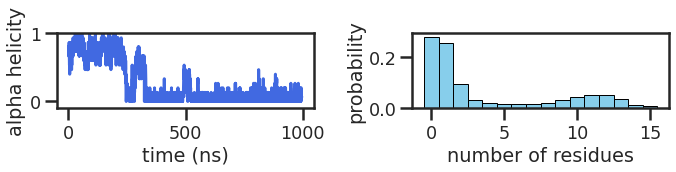

In [169]:
alpha_vs_t_list = [get_helicity(trajectory, topology, plotted=True, start=100)[1] for trajectory in trajectories]

## MSM on distance

In [130]:
import pyemma

distances_feat = pyemma.coordinates.featurizer(topology)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(trajectories, features=distances_feat)
distances_data = [distance_traj[100:] for distance_traj in distances_data]

Obtaining file info:   0%|          | 0/16 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/16 [00:00<?, ?it/s]

In [131]:
# Distance shows the highest VAMP score
distance_concat = np.concatenate(distances_data, axis=0)

In [132]:
tica = deeptime.decomposition.TICA(lagtime=50, dim=2)
tica = tica.fit(distances_data)
tica_output = [tica.transform(dist_traj) for dist_traj in distances_data]
tica_concat = np.concatenate(tica_output, axis=0)

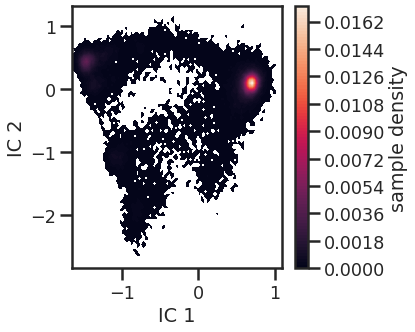

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
pyemma.plots.plot_density(tica_concat[:, 0], tica_concat[:, 1], ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
plt.tight_layout()
plt.show()

In [134]:
from deeptime.clustering import KMeans
from tqdm import tqdm

estimator = KMeans(
    n_clusters=100,  
    init_strategy='kmeans++',
    max_iter=100,
    fixed_seed=13,
    n_jobs=8,
    progress=tqdm
)

In [135]:
clustering = estimator.fit(tica_concat).fetch_model()
assignments = [clustering.transform(tica_output_traj) for tica_output_traj in tica_output]

KMeans iterations: 100%|██████████| 94/94 [00:04<00:00, 21.18it/s] 


In [136]:
assignments_concat = np.concatenate(assignments, axis=0)

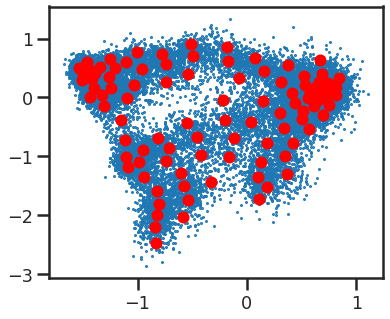

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(tica_concat[:, 0], tica_concat[:, 1], s=1)
ax.scatter(clustering.cluster_centers[:, 0], clustering.cluster_centers[:, 1], s=100, c='r')

In [138]:
lagtimes = [1, 2, 5, 8, 10, 15, 20, 30, 40, 50, 70, 100]

Text(0, 0.5, 'timescale (steps)')

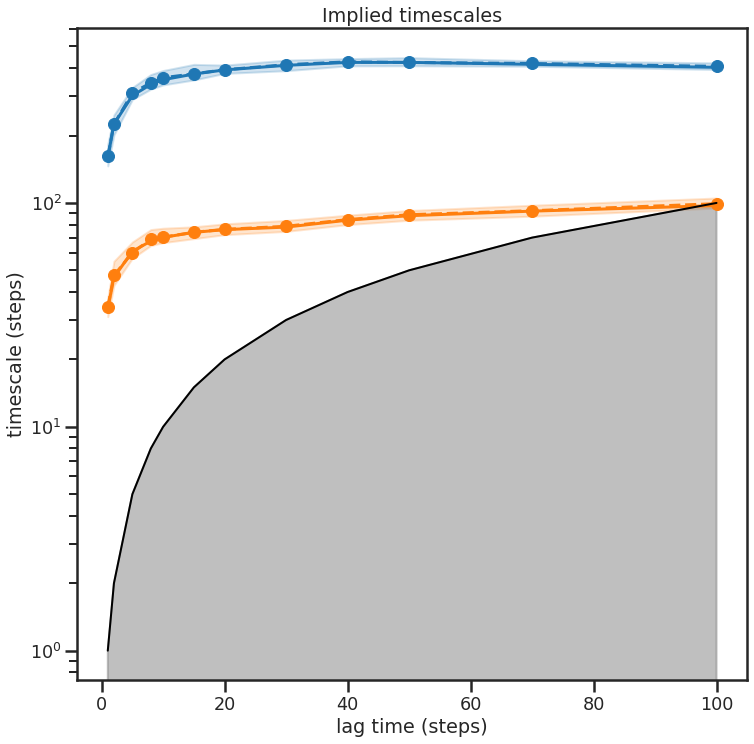

In [139]:
models = []
for lagtime in lagtimes:
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments)
    models.append(BayesianMSM(n_samples=50).fit_fetch(counts))

its_data = implied_timescales(models)

fig, ax = plt.subplots(1, 1)
plot_implied_timescales(its_data, n_its=2, ax=ax)
ax.set_yscale('log')
ax.set_title('Implied timescales')
ax.set_xlabel('lag time (steps)')
ax.set_ylabel('timescale (steps)')

In [140]:
models = []
for lag in lagtimes:
     counts_estimator = TransitionCountEstimator(lagtime=lag, count_mode='effective')
     models.append(BayesianMSM().fit_fetch(counts_estimator.fit_fetch(assignments)))

In [141]:
model = models[7]
print(f'Selected MSM: lagtime is: {model.lagtime} steps, {model.lagtime*dt} ns')

msm = model.prior

Selected MSM: lagtime is: 30 steps, 12.0 ns


In [142]:
msm_weights = msm.compute_trajectory_weights(assignments)

In [180]:
msm_weight_concat = np.concatenate(msm_weights)

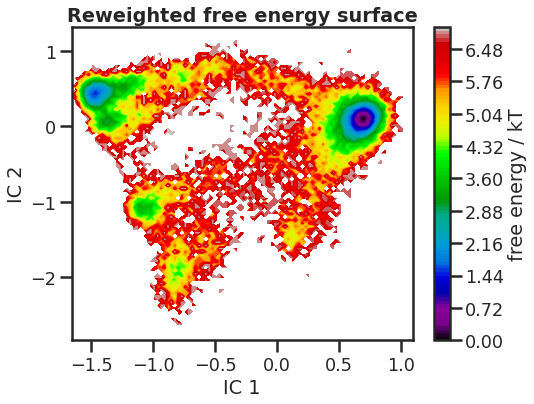

In [184]:
fig, ax = plt.subplots(figsize=(8, 6), sharex=True, sharey=True)
pyemma.plots.plot_free_energy(
    *tica_concat[:, :2].T,
    weights=np.concatenate(msm_weights),
    ax=ax,
    legacy=False)

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
ax.set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()

In [144]:
n_states = 2
pcca = msm.pcca(n_metastable_sets=n_states)

/nethome/yzhuang/git_repo/deeptime/deeptime/plots/chapman_kolmogorov.py:174: ComplexWarning: Your CKtest contains imaginary components which are ignored during plotting.
  warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",


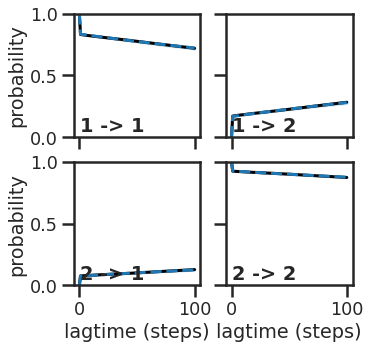

In [145]:
ck_test = model.ck_test(models, n_metastable_sets=n_states)
grid = plot_ck_test(ck_test, legend=False)

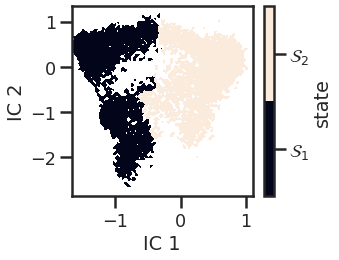

In [146]:
metastable_traj = [pcca.assignments[assignment] for assignment in assignments]
metastable_concat = np.concatenate(metastable_traj)

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concat[:, :2].T, metastable_concat, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(n_states)])
fig.tight_layout()

In [147]:
n_states = 4
pcca = msm.pcca(n_metastable_sets=n_states)

/nethome/yzhuang/git_repo/deeptime/deeptime/plots/chapman_kolmogorov.py:174: ComplexWarning: Your CKtest contains imaginary components which are ignored during plotting.
  warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",


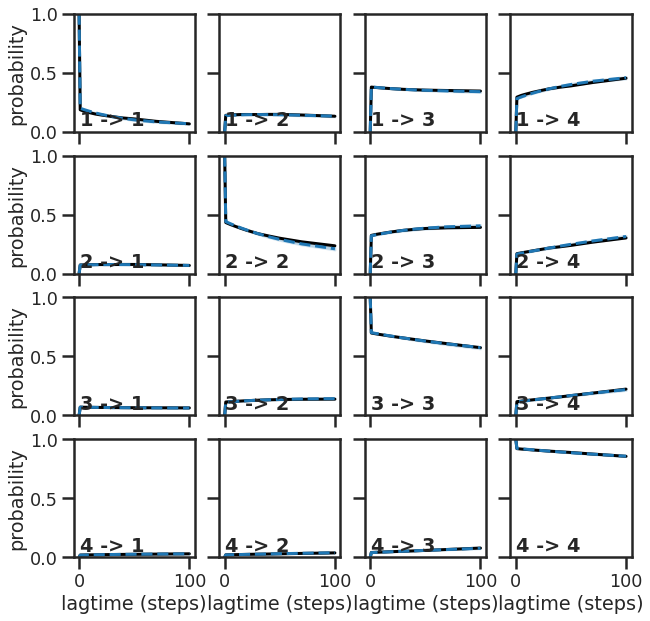

In [148]:
ck_test = model.ck_test(models, n_metastable_sets=n_states)
grid = plot_ck_test(ck_test, legend=False)

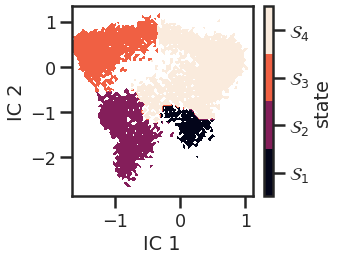

In [149]:
metastable_traj = [pcca.assignments[assignment] for assignment in assignments]
metastable_concat = np.concatenate(metastable_traj)

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concat[:, :2].T, metastable_concat, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(n_states)])
fig.tight_layout()

In [154]:
print('State 3: helix')
print('State 4: coil')

print('state\tG/kT')
for i, s in enumerate(pcca.sets):
    p = msm.stationary_distribution[s].sum()
    print('{}\t{:f}'.format(i + 1, -np.log(p)))
print('')

from itertools import product

mfpt = np.zeros((n_states, n_states))
mfpt_std = np.zeros((n_states, n_states))
for i, j in product(range(n_states), repeat=2):
    stats_mfpt = model.gather_stats("mfpt", A=pcca.sets[i], B=pcca.sets[j])

    mfpt[i, j] = stats_mfpt.mean * dt
    mfpt_std[i, j] = stats_mfpt.std * dt

print('MFPT +- std / ns:')
for i, j in product(range(n_states), repeat=2):
    if i != j:
        print(f'{i + 1} -> {j + 1}: {mfpt[i, j]:.2f} +- {mfpt_std[i, j]:.2f} ns')
print('')
print('mfpt coil to helix is {:.2f} ns'.format(mfpt[3, 2]))
print('mfpt helix to coil is {:.2f} ns'.format(mfpt[2, 3]))

State 3: helix
State 4: coil
state	G/kT
1	4.039762
2	2.516673
3	1.401889
4	0.422297

MFPT +- std / ns:
1 -> 2: 467.04 +- 20.79 ns
1 -> 3: 460.55 +- 14.42 ns
1 -> 4: 55.00 +- 3.30 ns
2 -> 1: 1221.15 +- 58.32 ns
2 -> 3: 217.84 +- 9.19 ns
2 -> 4: 158.47 +- 5.86 ns
3 -> 1: 1354.93 +- 59.18 ns
3 -> 2: 324.68 +- 13.35 ns
3 -> 4: 202.29 +- 7.11 ns
4 -> 1: 1245.66 +- 58.25 ns
4 -> 2: 619.20 +- 18.67 ns
4 -> 3: 515.69 +- 13.92 ns

coil to helix is 515.69 ns
helix to coil is 202.29 ns


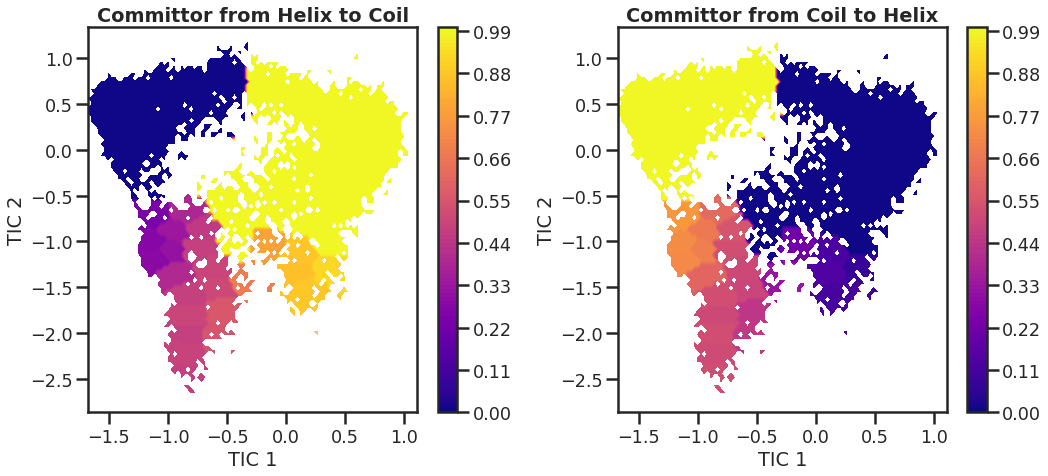

In [151]:
fig, axes = plt.subplots(1,2,figsize=(15, 7))

commitor = msm.committor_forward(pcca.sets[2], pcca.sets[3])
pyemma.plots.plot_contour(tica_concat[:, 0].T,
                                tica_concat[:, 1].T,
                                commitor[assignments_concat],
                                ax=axes[0],
                                mask=True,
                                cmap='plasma',
                                )
axes[0].set_xlabel('TIC 1')
axes[0].set_ylabel('TIC 2')
axes[0].set_title('Committor from Helix to Coil', fontweight='bold')

commitor = msm.committor_forward(pcca.sets[3], pcca.sets[2])
pyemma.plots.plot_contour(tica_concat[:, 0].T,
                                tica_concat[:, 1].T,
                                commitor[assignments_concat],
                                ax=axes[1],
                                mask=True,
                                cmap='plasma',
                                )
axes[1].set_xlabel('TIC 1')
axes[1].set_ylabel('TIC 2')
axes[1].set_title('Committor from Coil to Helix', fontweight='bold')
plt.tight_layout()
plt.show()

In [158]:
np.concatenate(alpha_vs_t_list).shape

(51987,)

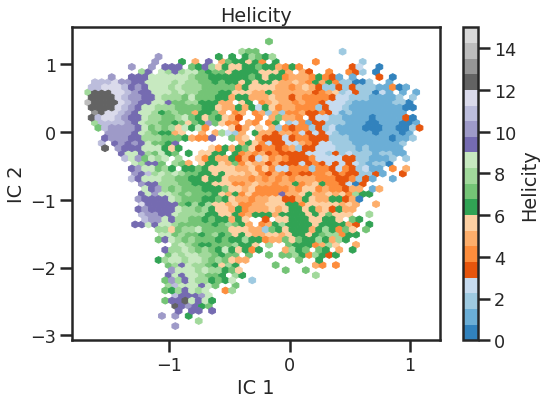

In [160]:
fig, ax = plt.subplots(figsize=(8, 6))
ax_bin = ax.hexbin(tica_concat[:, 0].T,
                                  tica_concat[:, 1].T,
                                  np.concatenate(alpha_vs_t_list),
                                  gridsize=50,
                                  vmin=0,
                                  vmax=15,
                                  cmap='tab20c',
                                 # cmap=cmap,
                                 )

ax.set_title('Helicity')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
plt.colorbar(ax_bin, label='Helicity')
plt.tight_layout()

In [161]:
def boltzmann_inverse(probabilities, kT=1):
    """Computes the inverse of the Boltzmann distribution for a given temperature.
    Parameters
    ----------
    probabilities : (N,) ndarray
        Probabilities to be transformed.
    kT : float, optional, default=1
        The value of kT in the desired energy unit.
    Returns
    -------
    inverse : (N,) ndarray
        Energy in kT.
        """
    return -np.log(probabilities) / kT

In [170]:
alpha_vs_t_list = [alpha_vs_t.astype(int) for alpha_vs_t in alpha_vs_t_list]
alpha_vs_t = np.concatenate(alpha_vs_t_list)
nframes = len(alpha_vs_t)
pmf_alpha = boltzmann_inverse(np.bincount(alpha_vs_t)/nframes)
pmf_alpha = pmf_alpha - np.min(pmf_alpha)

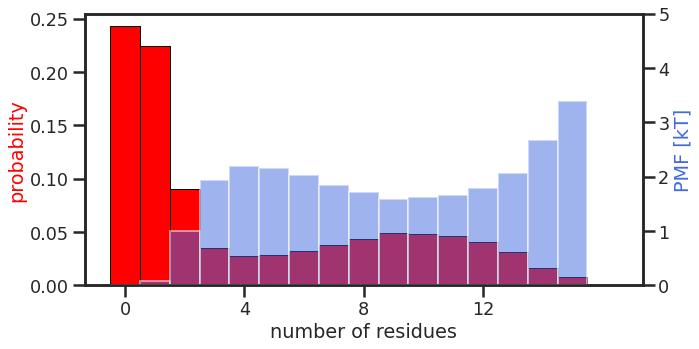

In [171]:
fig, ax = plt.subplots(figsize=(10,5))

ndihedrals = 16
ax.hist(alpha_vs_t,bins=ndihedrals+1,range=[-0.5,ndihedrals+0.5],density=True,stacked=True,color='red',ec='black',lw=1)
ax.set_xlabel('number of residues')
ax.set_ylabel('probability', color='red')

ax2 = ax.twinx()
ax2.bar(np.arange(16), pmf_alpha, width=1, color='royalblue', alpha=0.5)
ax2.set_ylabel('PMF [kT]', color='royalblue')
ax2.set_ylim(0,5)
ax.set_xticks(np.arange(0,16,4))
plt.show()

In [181]:
pmf_msm = boltzmann_inverse(np.bincount(alpha_vs_t, weights=msm_weight_concat)/nframes)
pmf_msm = pmf_msm - np.min(pmf_msm)

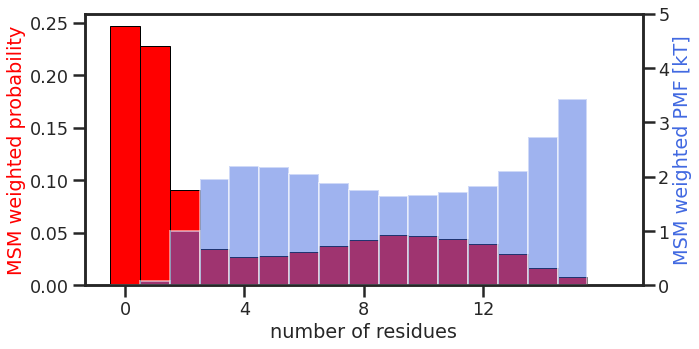

In [183]:
fig, ax = plt.subplots(figsize=(10,5))

ndihedrals = 16
ax.hist(alpha_vs_t, weights=msm_weight_concat,bins=ndihedrals+1,range=[-0.5,ndihedrals+0.5],density=True,stacked=True,color='red',ec='black',lw=1)
ax.set_xlabel('number of residues')
ax.set_ylabel('MSM weighted probability', color='red')

ax2 = ax.twinx()
ax2.bar(np.arange(16), pmf_msm, width=1, color='royalblue', alpha=0.5)
ax2.set_ylabel('MSM weighted PMF [kT]', color='royalblue')
ax2.set_ylim(0,5)
ax.set_xticks(np.arange(0,16,4))
plt.show()